# Alethea's Attempt at ResNet-50

In [1]:
import torch
from torch import nn
import matplotlib
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader

In [2]:
# CUDA for PyTorch
# Shamelessly stolen from: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

## Let's Build the Model

I'm basing this on the resnet diagram from: https://cv-tricks.com/keras/understand-implement-resnets/

In [4]:
class ConvModule(nn.Module):
    """Implements a single Convolution layer"""

    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, bias=True, 
                 padding_mode='zeros'):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              stride, padding, dilation, groups, 
                              bias, padding_mode)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv.forward(x))
        

In [5]:
#tmpmodel = ConvModule(in_channels=3, out_channels=3, kernel_size=3)
#print(list(tmpmodel.parameters()))

In [6]:
class MaxPoolModule(nn.Module):
    """Implements a single Max Pool layer"""

    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, 
                 return_indices=False, ceil_mode=False):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size, stride, padding, dilation, 
                                    return_indices, ceil_mode)
        
    def forward(self, x):
        return self.maxpool(x) 

In [7]:
class AvgPoolModule(nn.Module):
    """Implements a single Average Pool layer"""
    
    def __init__(self, kernel_size, stride=None, padding=0, ceil_mode=False, 
                 count_include_pad=True, divisor_override=None):
        super().__init__()
        self.avgpool = nn.AvgPool2d(kernel_size, stride, padding, ceil_mode, 
                                    count_include_pad, divisor_override)

    def forward(self, x):
        return self.avgpool(x) 

In [8]:
class LinearModule(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
    
    def forward(self, x):
        return self.linear(x)

In [9]:
#tmpmodel = LinearModule(in_features=100, out_features=100)
#print(list(tmpmodel.parameters()))

In [10]:
class SoftmaxModule(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.softmax = nn.Softmax(dim)
    
    def forward(self, x):
        return self.softmax(x)

In [11]:
class ResidualModule(nn.Module):
    """Implements a single residual block from a given stage"""
    
    def __init__(self, stage_num):
        super().__init__()

        # p = parameters
        p = {1: {'in_channels': [64, 64, 64], 
                 'out_channels': [64, 64, 256], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0], 
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
             2: {'in_channels': [128, 128, 128], 
                 'out_channels': [128, 128, 512], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0],
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
             3: {'in_channels': [256,256, 256], 
                 'out_channels': [256, 256, 1024], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0], 
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
             4: {'in_channels': [512, 512, 512], 
                 'out_channels': [512, 512, 2048], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0], 
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
            }[stage_num]
        
        # Pytorch doesn't seem to be able to find trainable parameters if we put submodules 
        # into an array
        #
        # for i in range(3):
        #     self.layers.append()

        i = 0
        self.layer0 = ConvModule(p['in_channels'][i], p['out_channels'][i], p['kernel_size'][i], 
                                 p['stride'][i], p['padding'][i], p['dilation'][i], 
                                 p['groups'][i], p['bias'][i], p['padding_mode'][i])
        i = 1
        self.layer1 = ConvModule(p['in_channels'][i], p['out_channels'][i], p['kernel_size'][i], 
                                 p['stride'][i], p['padding'][i], p['dilation'][i], 
                                 p['groups'][i], p['bias'][i], p['padding_mode'][i])
        i = 2
        self.layer2 = ConvModule(p['in_channels'][i], p['out_channels'][i], p['kernel_size'][i], 
                                 p['stride'][i], p['padding'][i], p['dilation'][i], 
                                 p['groups'][i], p['bias'][i], p['padding_mode'][i])
        
                    
    def forward(self, x):
        a = x
        a = self.layer0.forward(a)
        a = self.layer1.forward(a)
        a = self.layer2.forward(a) 
        return a + x


In [12]:
class Stage(nn.Module):
    """Implements each of the four stages of residual blocks. 
    One instance of this class is one stage"""
    
    def __init__(self, stage_num):
        super().__init__()
    
        
        # Pytorch doesn't seem to be able to find trainable parameters if we put submodules 
        # into an array
        #
        # self.stage_num = stage_num
        #
        # self.num_blocks = {1: 3, 
        #                    2: 3, 
        #                    3: 6, 
        #                    4: 3}[stage_num]
        #
        # self.blocks = []
        # for i in range(self.num_blocks):
        #     self.blocks.append(ResidualModule(stage_num))

        self.block0 = ResidualModule(stage_num)
        self.block1 = ResidualModule(stage_num)
        self.block2 = ResidualModule(stage_num)
        if stage_num == 3:
            self.block3 = ResidualModule(stage_num)
            self.block4 = ResidualModule(stage_num)
            self.block5 = ResidualModule(stage_num)
            
        
    def forward(self, x):
        # a = x
        # for block in self.blocks:
        #     a = block.forward(x)
        # return a
        a = x
        a = self.block0.forward(a)
        a = self.block1.forward(a)
        a = self.block2.forward(a)
        if stage_num == 3:
            a = self.block3.forward(a)
            a = self.block4.forward(a)
            a = self.block5.forward(a)
        return a

In [34]:
class ResNet50(nn.Module):

    def __init__(self, num_labels):
        super().__init__()
        
        # 7x7 Conv
        self.layer1 = ConvModule(in_channels=3, out_channels=64, 
                                 kernel_size=7, stride=2)

        # 3x3 MaxPool
        self.layer2 = MaxPoolModule(kernel_size=3, stride=2, padding=1)

        # Residual Stages
        self.stage1 = Stage(1)
        self.stage2 = Stage(2)
        self.stage3 = Stage(3)
        self.stage4 = Stage(4)

        # AveragePool
        self.avgpool = AvgPoolModule(kernel_size=7)  # FIXME
        
        # Fully Connected
        self.linear = LinearModule(in_features=1000, out_features=num_labels)
        
        # I think this one is handled by choosing criterion = nn.CrossEntropyLoss() below
        # self.softmax = SoftmaxModule(dim=num_labels)  # Is this needed? 

    def forward(self, x):
        a = x
        
        a = self.layer1.forward(a)
        a = self.layer2.forward(a)
        a = self.stage1.forward(a)
        a = self.stage2.forward(a)
        a = self.stage3.forward(a)
        a = self.stage4.forward(a)
        a = self.avgpool.forward(a)
        a = self.linear.forward(a)
        a = self.softmax.forward(a)
        return a

## Load our data. 

I'm using advice from https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/ about regularizing image data. 


In [35]:
transform = transforms.Compose([transforms.Resize(256),        
                                transforms.CenterCrop(224),    
                                transforms.ToTensor(),         
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                                                     std=[0.229, 0.224, 0.225])
                               ])


datadir = "/home/apower/data/oxford-iiit-pet"
traindir = os.path.join(datadir, 'train')
devdir = os.path.join(datadir, 'dev')
testdir = os.path.join(datadir, 'test')

X_train = torchvision.datasets.ImageFolder(traindir, transform)
X_dev = torchvision.datasets.ImageFolder(devdir, transform)
X_test = torchvision.datasets.ImageFolder(testdir, transform)


In [36]:
print('training_set:', len(X_train), '\ndev_set:', len(X_dev), '\ntest_set:', len(X_test))

training_set: 5760 
dev_set: 800 
test_set: 800


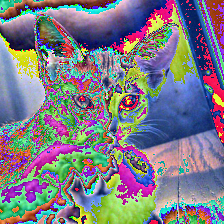

In [37]:
to_pic = torchvision.transforms.ToPILImage()
to_pic(X_train[0][0])

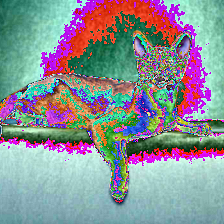

In [38]:
to_pic(X_dev[0][0])

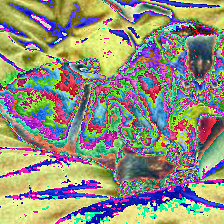

In [39]:
to_pic(X_test[0][0])

## Let's Do it


In [40]:
model = ResNet50(num_labels=len(X_train.classes))
if use_cuda:
    model.cuda()

In [41]:
#print(model)


In [42]:
#for p in model.parameters():
#    print(p)

Woohoo!!!! We have parameters! :-D

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [44]:
train_loader = DataLoader(X_train, batch_size=1, shuffle=True, num_workers=4)
dev_loader = DataLoader(X_dev, batch_size=1, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)



In [45]:
local_batch, local_labels = iter(train_loader).__next__()

In [46]:
X, y = local_batch.to(device), local_labels.to(device)

In [47]:
X, y

(tensor([[[[-1.9980, -1.9980, -2.0323,  ..., -1.1932, -1.1932, -1.2959],
           [-1.9980, -1.9980, -2.0152,  ..., -1.1075, -1.2103, -1.3644],
           [-2.0152, -2.0152, -2.0152,  ..., -0.9020, -1.1418, -1.1589],
           ...,
           [-0.9363, -0.8164, -0.5938,  ..., -0.4226, -0.3541, -0.6281],
           [-0.8164, -0.6623, -0.5253,  ..., -0.4054, -0.3883, -0.4568],
           [-0.6965, -0.5082, -0.3712,  ..., -0.4226, -0.5253, -0.5767]],
 
          [[-1.9307, -1.9307, -1.9657,  ..., -1.1779, -1.1604, -1.2654],
           [-1.9482, -1.9482, -1.9657,  ..., -1.1604, -1.1604, -1.3354],
           [-1.9482, -1.9657, -1.9657,  ..., -0.9153, -1.1253, -1.1253],
           ...,
           [-1.1604, -1.0378, -0.7927,  ..., -0.4601, -0.3725, -0.6527],
           [-1.0378, -0.8978, -0.7402,  ..., -0.4426, -0.4251, -0.4951],
           [-0.9328, -0.7402, -0.6176,  ..., -0.4426, -0.5476, -0.5826]],
 
          [[-1.7347, -1.7347, -1.7347,  ..., -0.9853, -0.9853, -1.0898],
           [-

In [48]:
X, y  # 3 channels x 224 x 224
print('X', X.size(), 'y:', y.size())
a1 = model.layer1.forward(X)
print('a1:', a1.size())
a2 = model.layer2.forward(X)
print('a2:', a2.size())

# T2 = model.layer1.forward(torch.tensor([T]))

#model.forward(T)


X torch.Size([1, 3, 224, 224]) y: torch.Size([1])
a1: torch.Size([1, 64, 109, 109])
a2: torch.Size([1, 3, 112, 112])


In [ ]:
max_epochs = 100

losses = []
for epoch in range(max_epochs):
    for local_batch, local_labels in train_loader:
        # Transfer to GPU
        X, y = local_batch.to(device), local_labels.to(device)
        y_pred = model.forward(X)
        loss = criterion(y_pred, y)
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:', epoch, 'loss:', loss.item())
